### Эволюция трансформеров: от GPT-1 до наших дней

#### GPT-серия

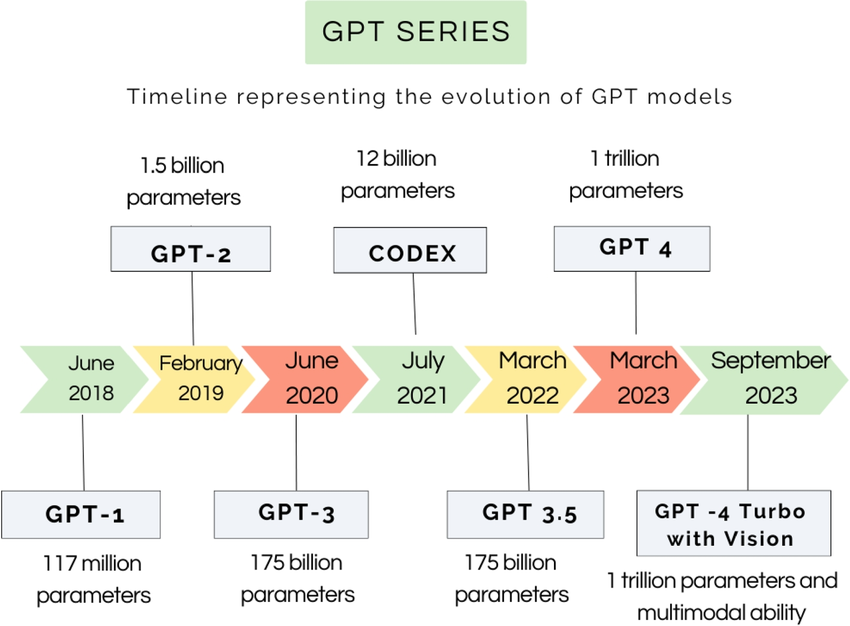

**GPT-1**

- Архитектура: 12-слойный декодер с 117 млн параметров.

- Обучена на BooksCorpus (5 ГБ текста).

- Есть возможность дообучения под конкретные задачи (классификация, генерация и т. д.).


**GPT-2**

- Архитектура: 1.5 млрд параметров (48 слоёв).

- Обучена на 40 ГБ текста из интернета и параметров.

- Появилась способность Zero-shot learning — выполнять задачи без предварительно дообучения на них

Многослойный self-attention с модификациями для стабильности.


**GPT-3**

- Архитектура: 175 млрд параметров (96 слоёв).

- Обучена на Common Crawl, Wikipedia, книгах и др. (~570 ГБ).

- Появилась способоность Few-shot learning — решает задачи по нескольким примерам в промпте.

- Sparse attention (экономия вычислений).

**GPT-3.5**

- Добавили оптимизация обучения (RLHF — Reinforcement Learning from Human Feedback).

- Появилась поддержка диалоговых сценариев


#### Открытые модели

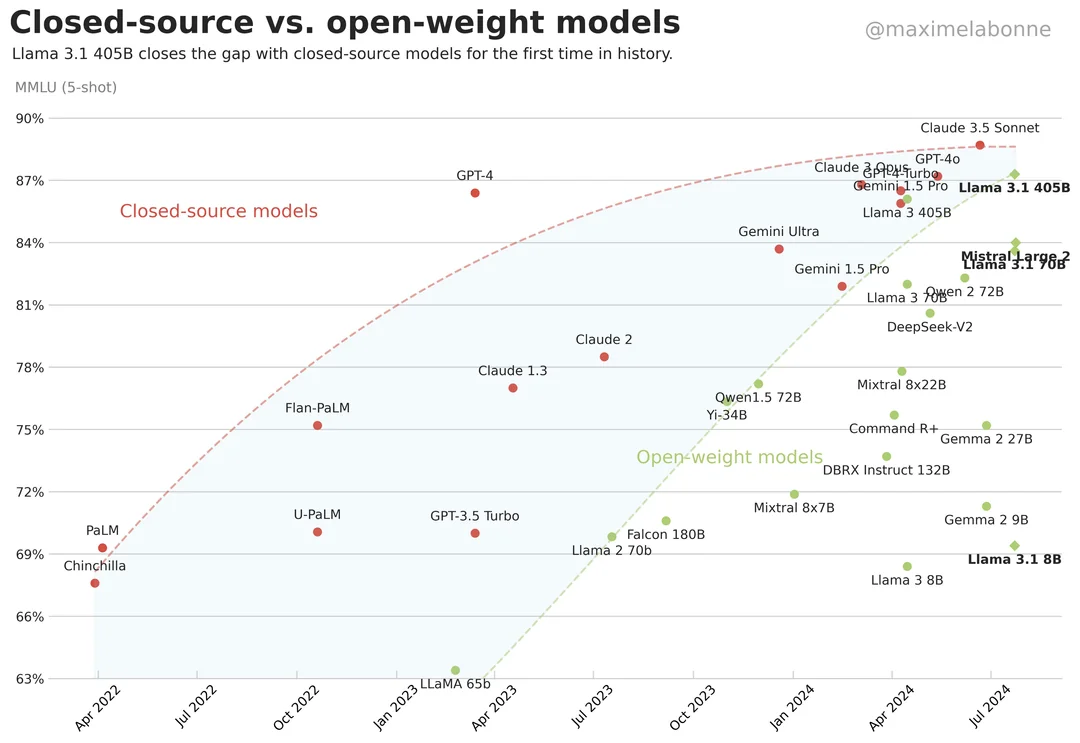

Ключевые направления для развития LLM:

- Эффективность — снижение вычислительных затрат.

- Длина контекста — обработка длинных последовательностей (100K+ токенов).

- Мультимодальность — работа с текстом, изображениями, аудио.

- Интерпретируемость — понимание механизмов внимания.

- Безопасность — контроль генерации и снижение bias.

### Positional Encoding (PE)

#### Sinusoidal Positional Encoding

Вектору каждого токена на входе добавляем вектор абсолютной позиции, может быть обучаемым, может быть какой-то функцией от позиции, например, sin/cos

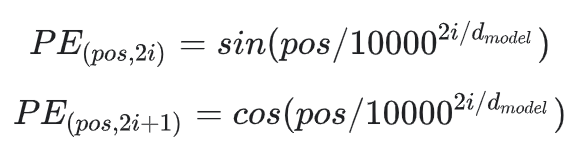

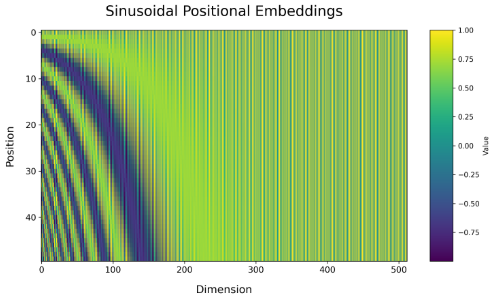

Плюсы:
* можно закодировать любую позицию, в том числе превосходящую максимальную длину, на которой тренировались;
* не требуется обучение.

Минусы:
* не очень работает на длинных последовательностях;
* в целом тоже не очень хорошо работает.

#### Обучаемые эмбеддинги

Как альтернатива подходу выше, была предложена схема, в которой каждая позиция получает свой обучаемый вектор (отдельная матрица `nn.Embedding`, как для эмбеддингов токенов)


Например, в [BERT](https://github.com/huggingface/transformers/blob/d1b92369ca193da49f9f7ecd01b08ece45c2c9aa/src/transformers/models/bert/modeling_bert.py#L978)

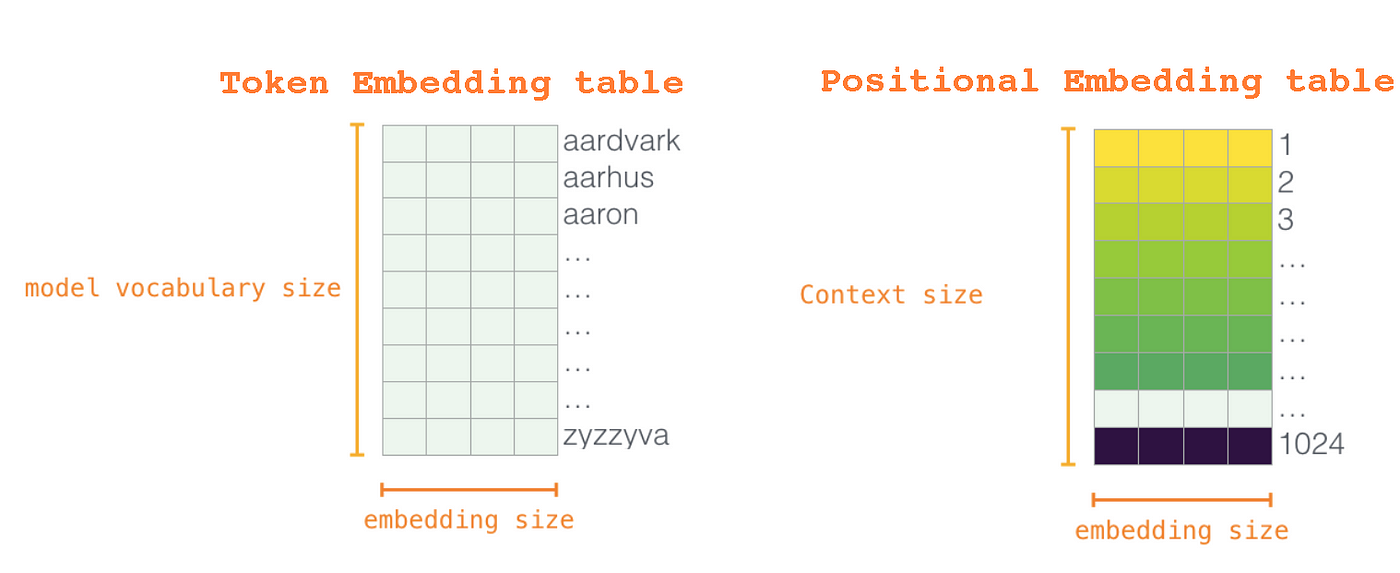

Плюсы - модель сама учит полезные паттерны, хорошо работает на коротких и средних последовательностях.

Минусы - не обобщается на позиции вне обучающего диапазона, требует больше памяти.

#### RPE - Relative Positional Encoding

Идея - нам важны не столько абсолютные позиции слов, сколько относительные, то есть близость каждой пары токенов.

Тогда будем на стадии attention, когда считаем $q_i*k_j$ добавлять туда эмбеддинг разности $i-j$.

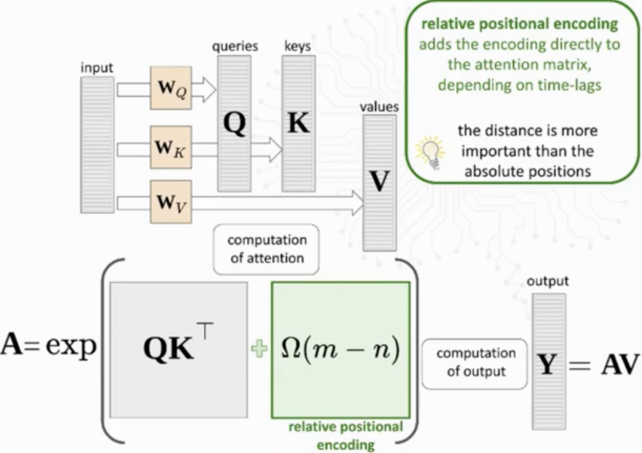

#### RoPE - Rotary Position Embedding

Основная идея - на стадии attention будем поворачивать вектора $q$ и $k$ в зависимости от позиции токена.

Если точнее: берём эмбеддинги и бьём их группами по два элемента, берём позицию и обозначаем каждой группе угол поворота  $θ$

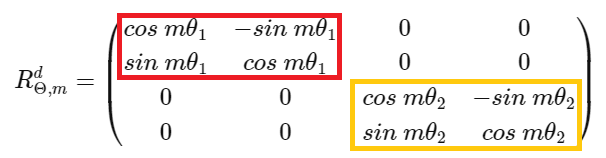

В отличие от RPE, RoPE:

- не добавляет отдельные эмбеддинги позиций к векторам токенов.

- модифицирует $q$ и $k$ через поворот в многомерном пространстве.

- сохраняет относительные расстояния: Attention score между двумя токенами зависит только от разности их позиций $i - j$.

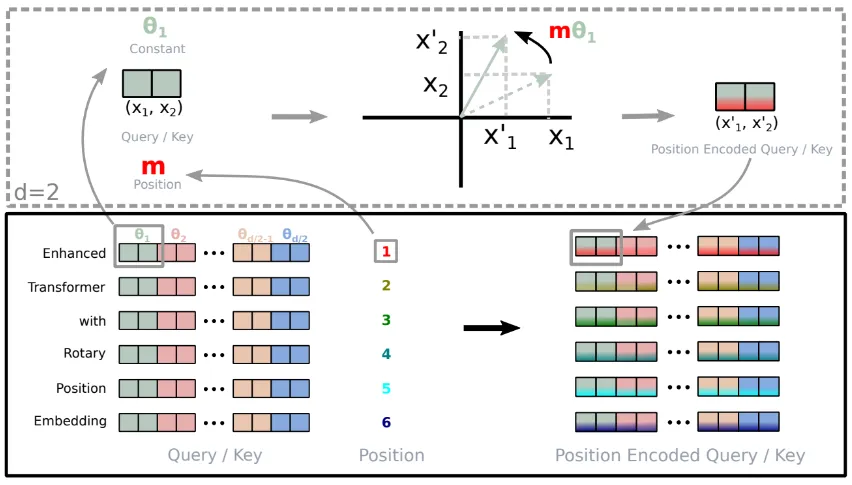

Плюсы:

- сохраняет относительные расстояния при любых длинах.

- экстраполируется на очень длинные последовательности.


#### Positional Interpolation

Если подать на вход модели последовательность длиннее, чем на обучении, позиционные эмбеддинги (PE) становятся "незнакомыми" для модели, что резко ухудшает качество.

Что тогда делать, когда длина последовательности больше той, на которой учились?


Просто экстраполировать не получится:

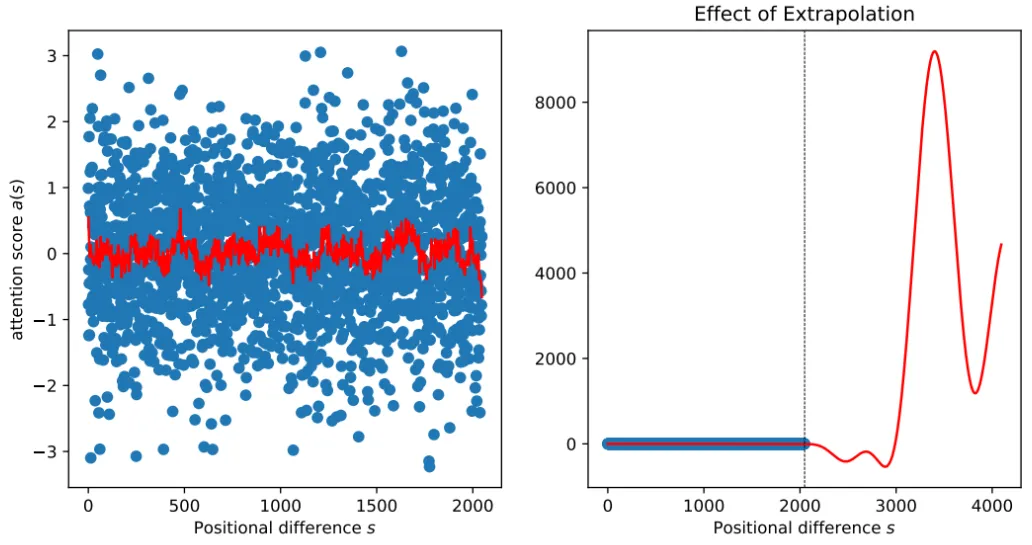

Тогда интерполируем!

Вместо того чтобы использовать "сырые" позиционные эмбеддинги для позиций > L_train, PI линейно сжимает все позиции в диапазон [0, L_train], сохраняя структуру относительных расстояний.

`position = position * (L_train / L_new)`

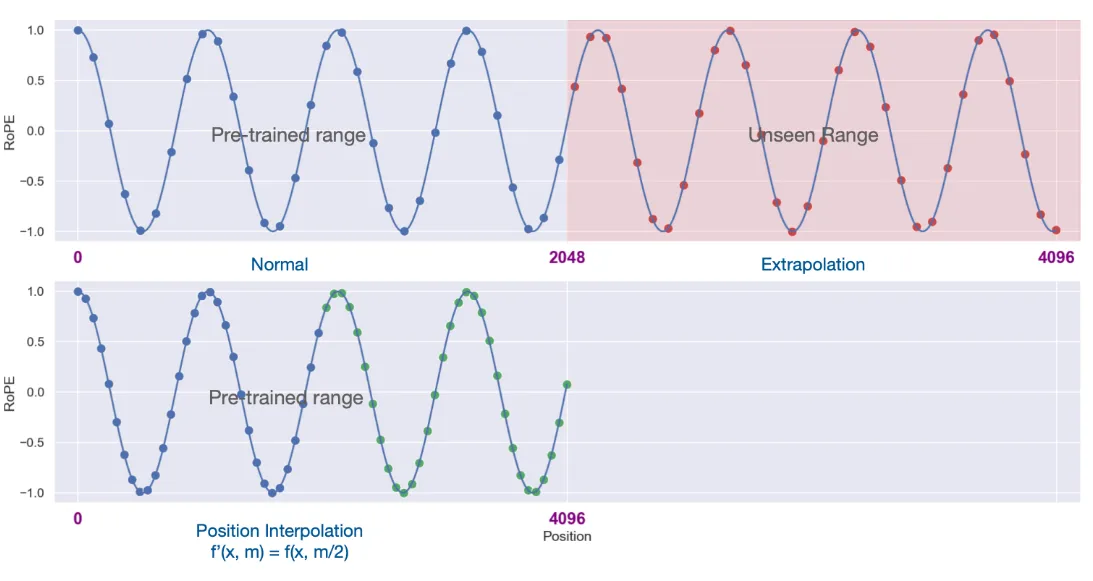

Итого имеем:

- сохранение относительных расстояний: Разница между позициями $i$ и $j$ уменьшается пропорционально $((i - j) / scale)$

- плавность: интерполяция избегает резких скачков в эмбеддингах для позиций чуть выше $L_{train}$

- совместимость с RoPE: RoPE кодирует позиции через вращения, и интерполяция просто "замедляет" угол поворота

#### NoPE

Идея - модель может извлекать позиционную информацию из самих данных или механизма внимания, без явных эмбеддингов позиций.

Может работать, потому что:

- модели склонны фокусироваться на близких токенах в attention, что создаёт неявный порядок.
- в текст уже есть структура - порядок предложений, пунктуация, ...
- можно реализовать через архитектурныые ограничения, например, использовать группировку токенов (chunking) и локальное внимание внутри блоков.

### Attention

#### Sparse Attention

Идея - ограничить область внимания, чтобы уменьшить сложность.

Наиболее показательна в этом отношении модель [BigBird](https://arxiv.org/abs/2007.14062), которая  использует три типа внимания


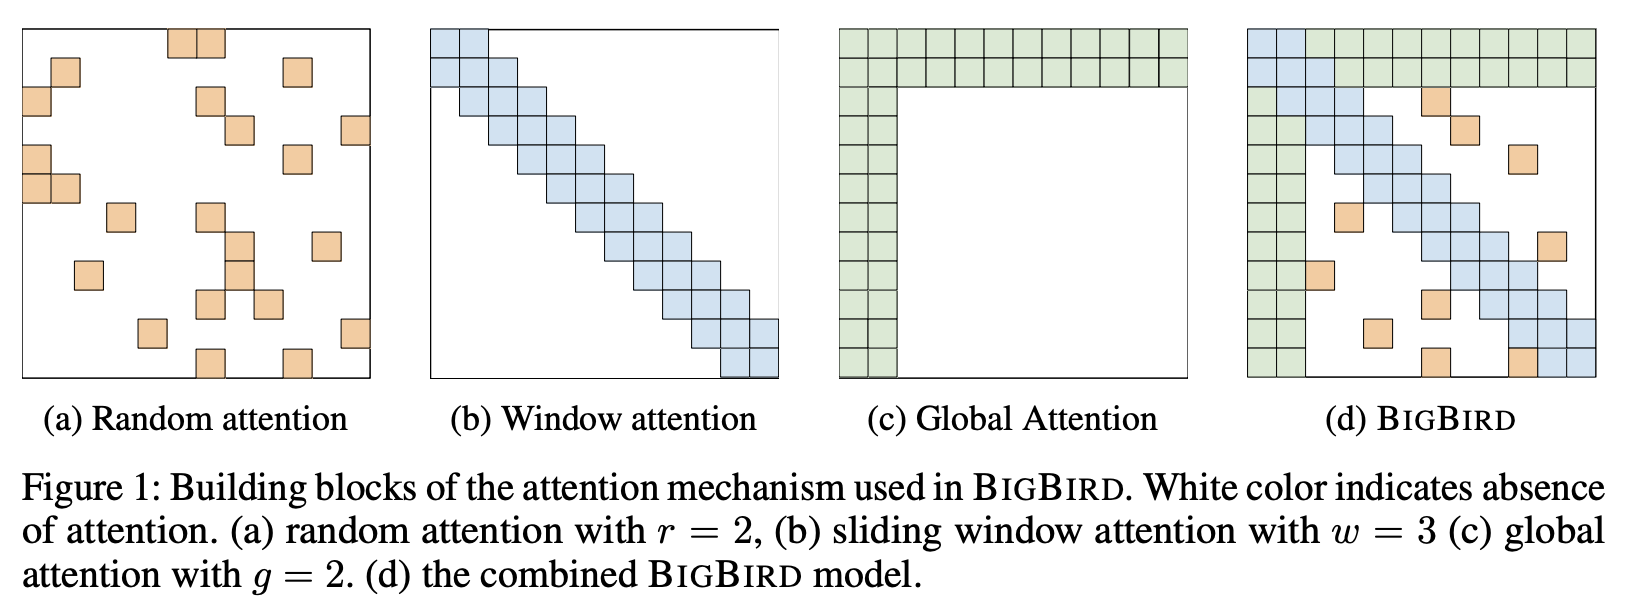

- Локальное внимание — гарантирует учёт ближайшего контекста.

- Случайное внимание — обеспечивает связь между далёкими токенами.

- Глобальные токены — играют роль хабов, собирающих информацию.

#### Linear Attention

Идея - замена softmax на ядерные методы

Вспомним неповторимый оригинал:

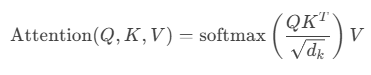


Рамерности матриц $Q, K, V$ - $N * d$, поэтому произведение в скобочках делать тяжело



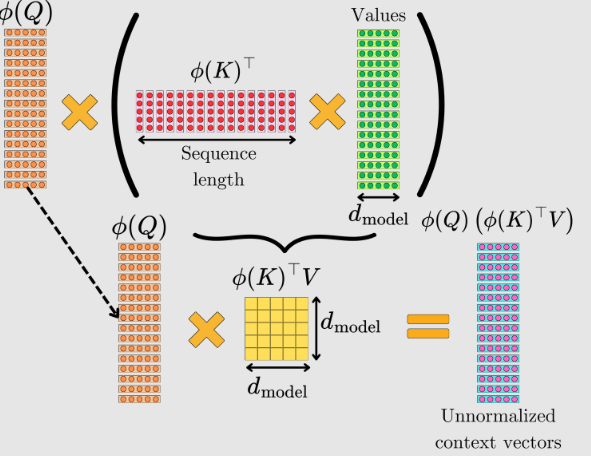

Давайте тогда применим kernel-trick, и введем какую-то функцию $ϕ$ для линеаризации и ассоциативности:

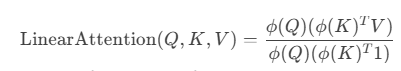

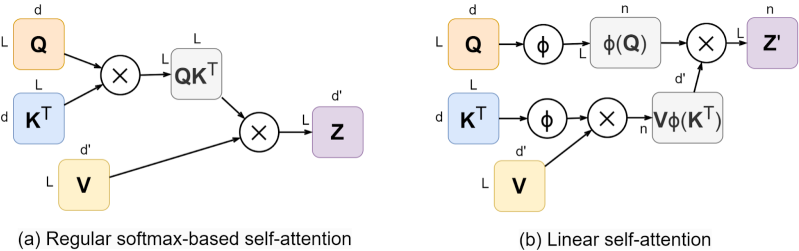

**Остается вопрос: какую функцию взять?**

- [Rethinking Attention with Performers](https://arxiv.org/abs/2009.14794)

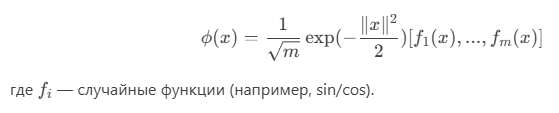
- [Linformer: Self-Attention with Linear Complexity](https://arxiv.org/abs/2006.04768)

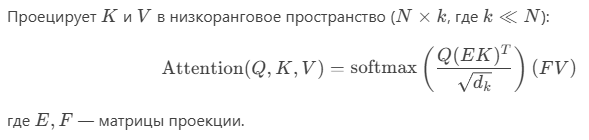
- [cosFormer: Rethinking Softmax in Attention](https://arxiv.org/abs/2202.08791)

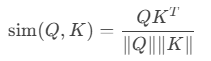

#### Multi Head VS Grouped Query VS Multi Query Attention

**Multi Query Attention** - вариант механизма внимания, в котором $Q$ остаются уникальными для каждой головы, а $K$ и $V$ становятся общими для всех голов

**Grouped Query Attention** — гибридный механизм внимания, сочетающий преимущества Multi-Head Attention и Multi-Query Attention:

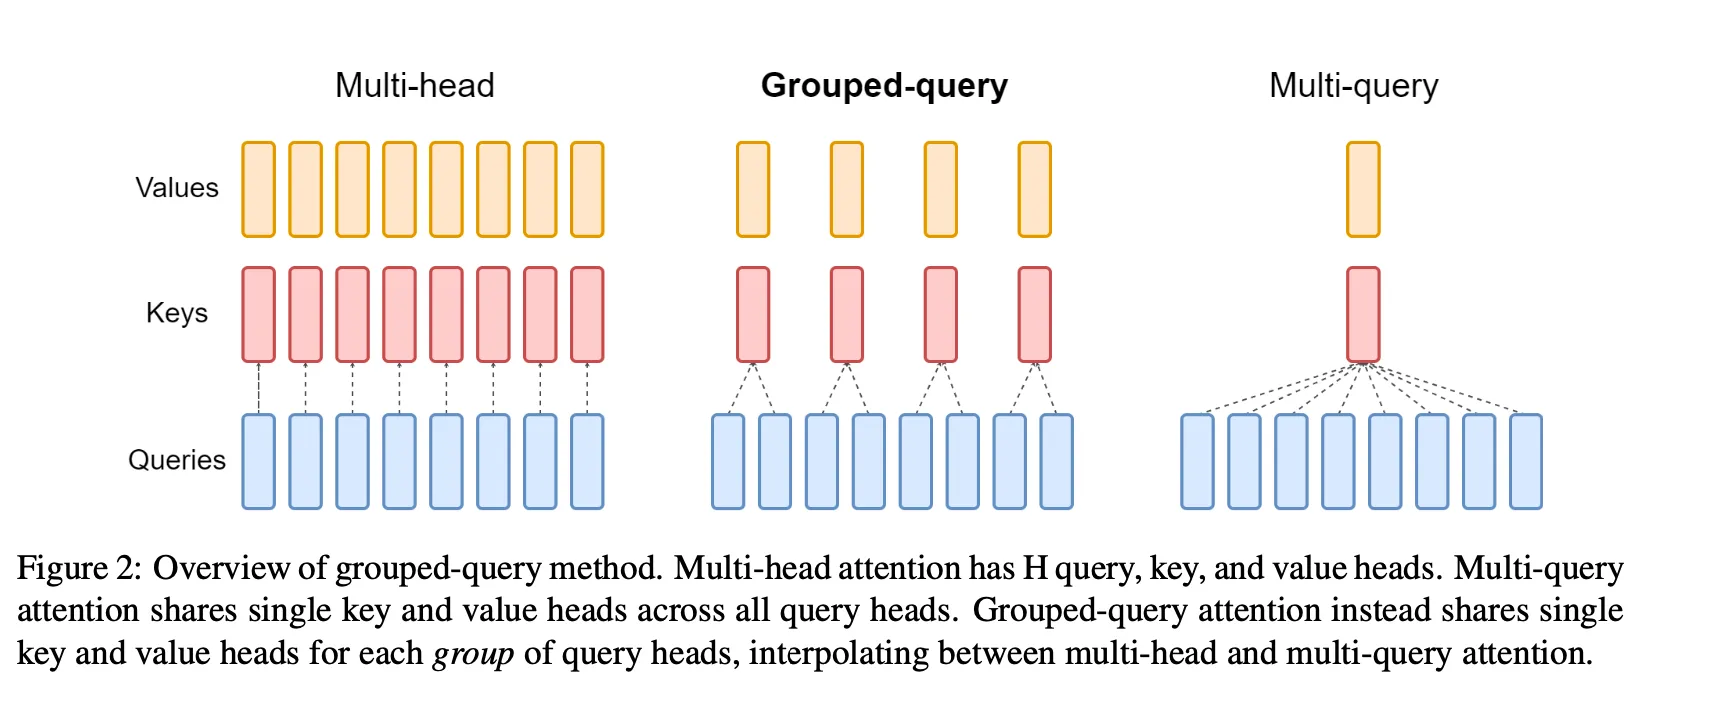

#### FlashAttention

[FlashAttention: Fast and Memory-Efficient Exact Attention
with IO-Awareness](https://arxiv.org/pdf/2205.14135)

Идея - оптимизация GPU-памяти и перерасчет.

Ключевым ингредиентом успеха Flash Attention является наблюдение того, что основное время уходит не сколько на сами вычисления, а на обращения к памяти, подрузку матриц и тензоров.

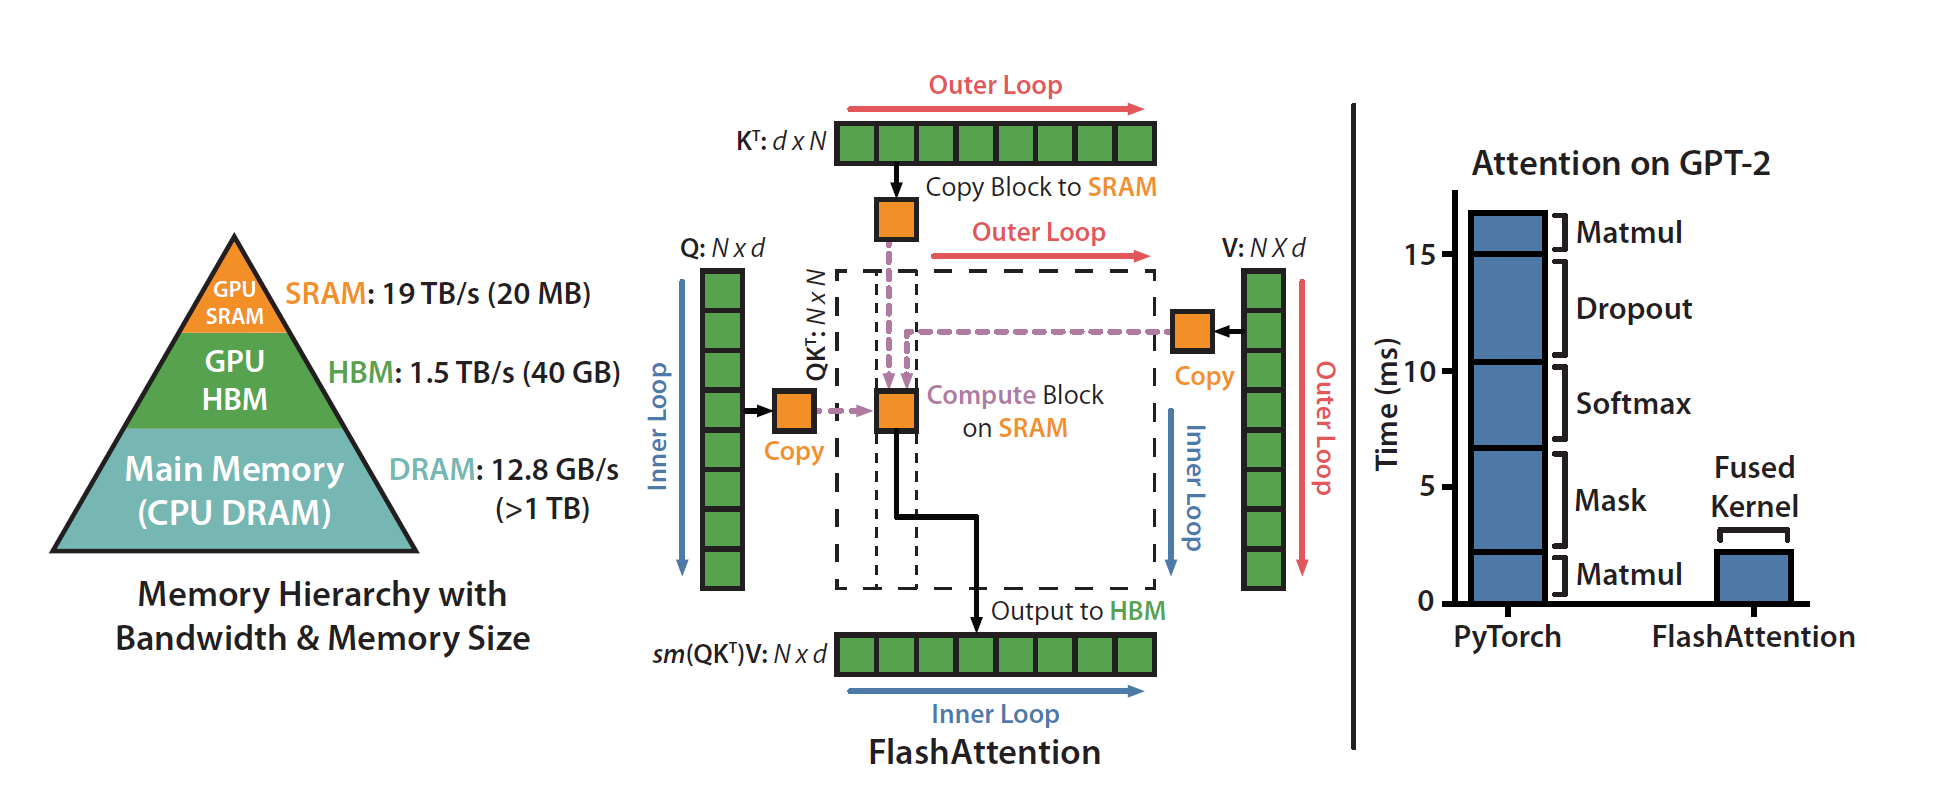

Память видеокарты имеет следующую иерархию: есть быстрая кэш память, которой немного, всего пара десятков мегабайт (Static Random Access Memory), и относительно медленная, но которой может быть много HBM (High Bandwidth Memory).

Казалось бы, что величина пропускной способности порядка 1 Тб/с это довольно много, но в случае обучения или инференса модели трансформера, HBM память не поспевает за вычислениями.

Стандартная реализация Attention:

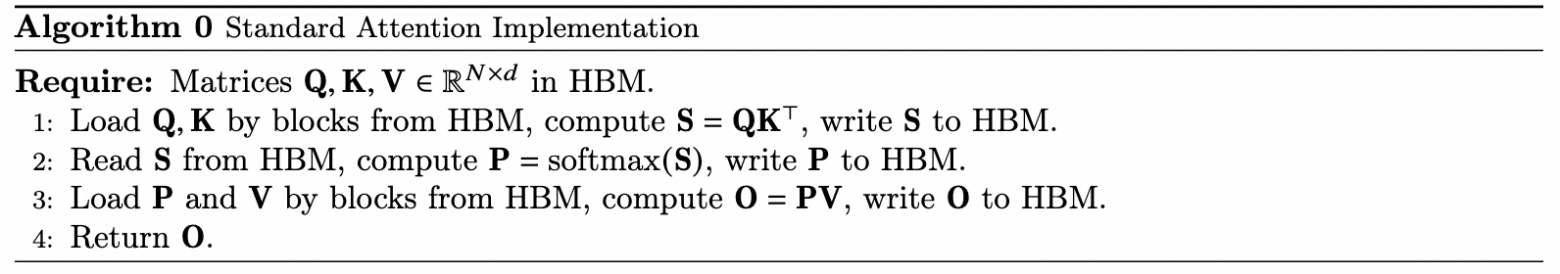

Что делает FlashAttention?

- Оптимизация доступа к памяти - Матрицы Q, K, V разбиваются на небольшие блоки, которые помещаются в быструю SRAM (регистры GPU). Вычисления происходят внутри блоков без постоянного обращения к HBM
- Перерасчет (Recomputation) вместо хранения - вместо хранения матриц QKᵀ и softmax, они пересчитываются на лету во время backward pass
- Объединение операций в один GPU-ядро: Softmax + масштабирование + dropout выполняются за один проход, нет промежуточных записей в память

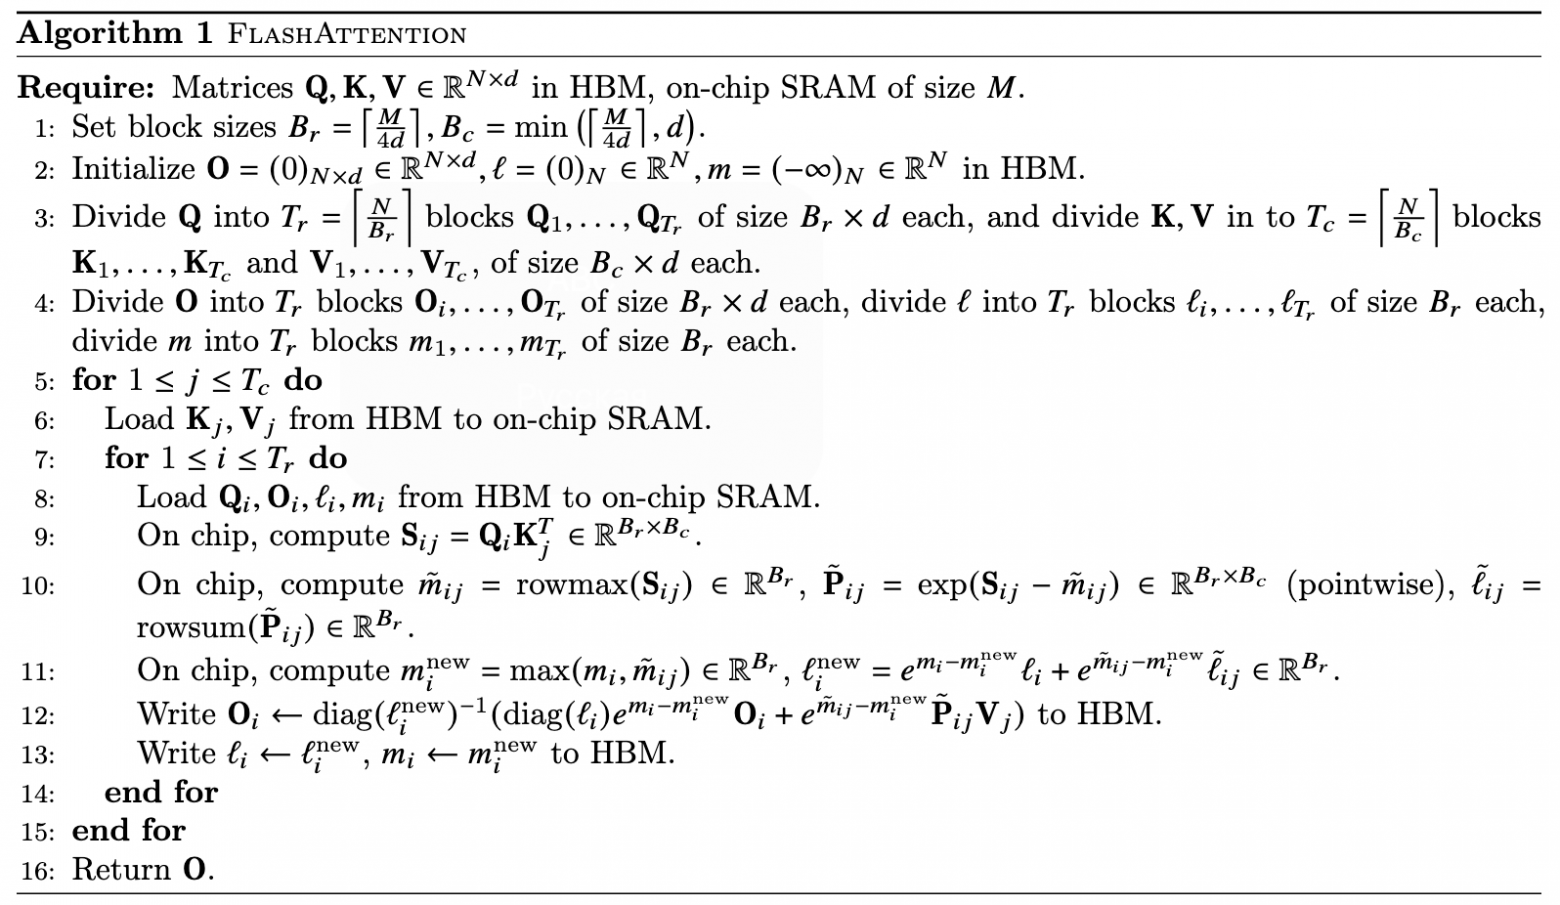

Поблочная процедура вычисления позволяет выполнять все операции (перемножения матриц, softmax, dropout) разом в одном СUDA kernel, в отличие от стандартной имплементации, где приходилось бы на каждую из операций вызывать отдельное ядро, что приводило к дополнительным накладным расходам.

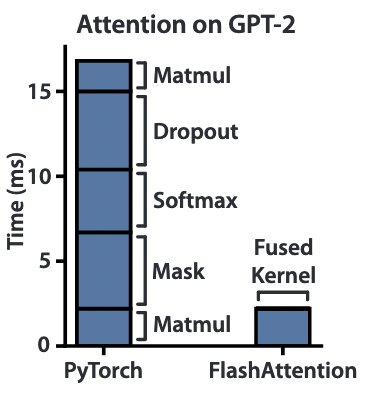

[ELI5: FlashAttention](https://gordicaleksa.medium.com/eli5-flash-attention-5c44017022ad)